In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

print('start')
rankings = pd.read_csv('fifa_ranking.csv')
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]
rankings = rankings.replace({"IR Iran": "Iran"})
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])
# print(rankings['rank_date'].head())
print(rankings.head())
print('\n_______________\n')


matches = pd.read_csv('results.csv')
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])
print(matches.head())

world_cup = pd.read_csv('World Cup 2018 Dataset.csv')
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
world_cup = world_cup.set_index('Team')
print('stop')

start
   rank country_full country_abrv  cur_year_avg_weighted  rank_date  \
0     1      Germany          GER                    0.0 1993-08-08   
1     2        Italy          ITA                    0.0 1993-08-08   
2     3  Switzerland          SUI                    0.0 1993-08-08   
3     4       Sweden          SWE                    0.0 1993-08-08   
4     5    Argentina          ARG                    0.0 1993-08-08   

   two_year_ago_weighted  three_year_ago_weighted  weighted_points  
0                    0.0                      0.0              0.0  
1                    0.0                      0.0              0.0  
2                    0.0                      0.0              0.0  
3                    0.0                      0.0              0.0  
4                    0.0                      0.0              0.0  

_______________

        date home_team away_team  home_score  away_score tournament     city  \
0 1872-11-30  Scotland   England           0           

In [24]:
# I want to have the ranks for every day 
print('start')
rankings2=rankings.copy(deep=False)
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# print(rankings.head())
# rankings1=rankings2.set_index(['rank_date'])\
#             .groupby(['country_full'], group_keys=False)\
#     .resample('D').first()\
#     .fillna(method='ffill')\
#     .reset_index()
# print(rankings.head())

# join the ranks
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
print(matches.head())
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))
print('\n____________________\n')
print(matches.head())


start
        date home_team     away_team  home_score  away_score  \
0 1993-08-08   Bolivia       Uruguay           3           1   
1 1993-08-08    Brazil        Mexico           1           1   
2 1993-08-08   Ecuador     Venezuela           5           0   
3 1993-08-08    Guinea  Sierra Leone           1           0   
4 1993-08-08  Paraguay     Argentina           1           3   

                     tournament      city   country  neutral  rank_date  rank  \
0  FIFA World Cup qualification    La Paz   Bolivia    False 1993-08-08  59.0   
1                      Friendly    Maceió    Brazil    False 1993-08-08   8.0   
2  FIFA World Cup qualification     Quito   Ecuador    False 1993-08-08  35.0   
3                      Friendly   Conakry    Guinea    False 1993-08-08  65.0   
4  FIFA World Cup qualification  Asunción  Paraguay    False 1993-08-08  67.0   

  country_full country_abrv  cur_year_avg_weighted  two_year_ago_weighted  \
0      Bolivia          BOL                  

In [25]:
# feature generation
print('start')
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost
matches['is_stake'] = matches['tournament'] != 'Friendly'

# I tried earlier rest days but it did not turn to be useful
max_rest = 30
matches['rest_days'] = matches.groupby('home_team').diff()['date'].dt.days.clip(0,max_rest).fillna(max_rest)

# I tried earlier the team as well but that did not make a difference either
matches['wc_participant'] = matches['home_team'] * matches['home_team'].isin(world_cup.index.tolist())
matches['wc_participant'] = matches['wc_participant'].replace({'':'Other'})
matches = matches.join(pd.get_dummies(matches['wc_participant']))
print('stop')

start
stop


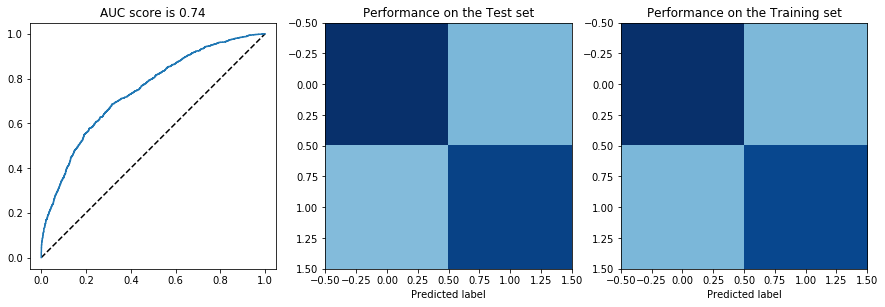

In [26]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)

# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')
plt.show()
# print('stop')
#pass

count      3696
unique        2
top       False
freq       2521
Name: is_won, dtype: object
count    1175.000000
mean        8.746366
std       122.811376
min     -1208.920000
25%         0.000000
50%         0.000000
75%         0.000000
max      1055.880000
Name: point_difference, dtype: float64


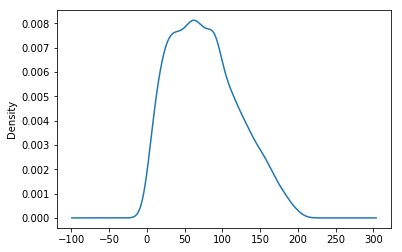

In [26]:

X_test.describe()
# 
X_test['average_rank'].describe()
X_test['average_rank'].plot.kde()
wrongs = y_test != model.predict(X_test)
print(wrongs.describe())
print(X_test.loc[wrongs, feature].describe())
plt.show()

Stakes distribution in the wrong predictions
True     0.577872
False    0.422128
Name: is_stake, dtype: float64
Stakes distribution overall
True     0.615618
False    0.384382
Name: is_stake, dtype: float64


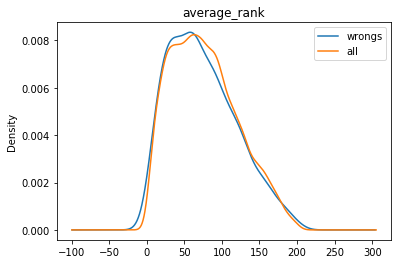

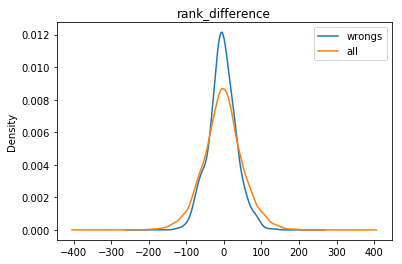

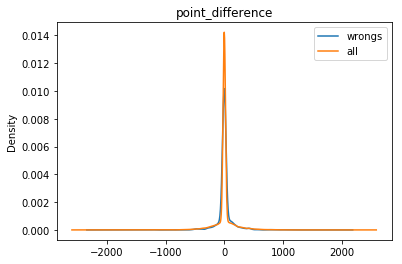

In [27]:
features = ['average_rank', 'rank_difference', 'point_difference']
wrongs = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])
plt.show()

In [28]:
# let's define a small margin when we safer to predict draw then win
margin = 0.05

# let's define the rankings at the time of the World Cup
world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])
world_cup_rankings.head()

,rank_date,rank,country_abrv,cur_year_avg_weighted,two_year_ago_weighted,three_year_ago_weighted,weighted_points
country_full,,,,,,,
Argentina,2018-06-07,5.0,ARG,404.07,248.99,183.59,836.65
Australia,2018-06-07,36.0,AUS,366.60,98.16,59.79,524.55
Belgium,2018-06-07,3.0,BEL,629.98,158.94,186.58,975.50
Brazil,2018-06-07,2.0,BRA,558.95,168.06,162.38,889.39
Colombia,2018-06-07,16.0,COL,292.09,199.73,166.38,658.20


In [37]:
from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0
for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))
    a=combinations(world_cup.query('Group == "{}"'.format(group)).index,2)
    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        
        home_win_prob = model.predict_proba(row)[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1

___Starting group H:___
   average_rank  rank_difference  point_difference  is_stake
0           NaN              NaN               NaN       1.0
Poland vs. Senegal: Poland wins with 0.60
Poland vs. Colombia: Draw
Poland vs. Japan: Poland wins with 0.73
Senegal vs. Colombia: Colombia wins with 0.59
Senegal vs. Japan: Senegal wins with 0.65
Colombia vs. Japan: Colombia wins with 0.70
___Starting group E:___
   average_rank  rank_difference  point_difference  is_stake
0           NaN              NaN               NaN       1.0
Brazil vs. Switzerland: Draw
Brazil vs. Costa Rica: Brazil wins with 0.62
Brazil vs. Serbia: Brazil wins with 0.67
Switzerland vs. Costa Rica: Switzerland wins with 0.59
Switzerland vs. Serbia: Switzerland wins with 0.65
Costa Rica vs. Serbia: Draw
___Starting group C:___
   average_rank  rank_difference  point_difference  is_stake
0           NaN              NaN               NaN       1.0
France vs. Australia: France wins with 0.65
France vs. Peru: Draw
France 

In [38]:
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points

        home_win_prob = model.predict_proba(row)[:,1][0]
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Uruguay vs. Spain: Spain wins with probability 0.54
Denmark vs. Croatia: Denmark wins with probability 0.55
Brazil vs. Mexico: Brazil wins with probability 0.58
Belgium vs. Colombia: Belgium wins with probability 0.59
Egypt vs. Portugal: Portugal wins with probability 0.81
France vs. Argentina: Argentina wins with probability 0.53
Switzerland vs. Germany: Germany wins with probability 0.60
England vs. Poland: Poland wins with probability 0.53


___Starting of the quarterfinal___
Spain vs. Denmark: Denmark wins with probability 0.51
Brazil vs. Belgium: Belgium wins with probability 0.51
Portugal vs. Argentina: Portugal wins with probability 0.51
Germany vs. Poland: Germany wins with probability 0.57


___Starting of the semifinal___
Denmark vs. Belgium: Belgium wins with probability 0.57
Portugal vs. Germany: Germany wins with probability 0.56


___Starting of the final___
Belgium vs. Germany: Germany wins with probability 0.54




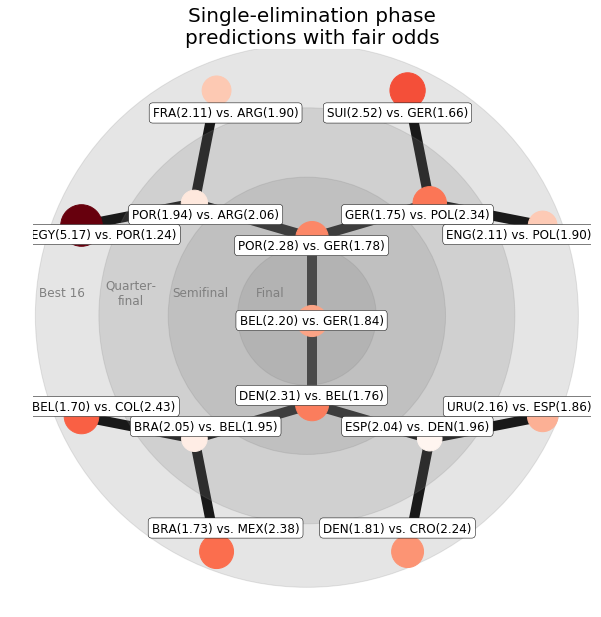

In [39]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

node_sizes = pd.DataFrame(list(reversed(odds)))
scale_factor = 0.3 # for visualization
G = nx.balanced_tree(2, 3)
pos = graphviz_layout(G, prog='twopi', args='')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)
# add circles 
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), 
                          cp, color='grey', 
                          alpha=0.2)) for cp, c in circle_positions]

# draw first the graph
nx.draw(G, pos, 
        node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor), 
        node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000, 
        alpha=1, 
        cmap='Reds',
        edge_color='black',
        width=10,
        with_labels=False)

# draw the custom node labels
shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
nx.draw_networkx_labels(G, 
                        pos=shifted_pos, 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(labels))), labels)))

texts = ((10, 'Best 16', 'black'), (70, 'Quarter-\nfinal', 'blue'), (130, 'Semifinal', 'red'), (190, 'Final', 'yellow'))
[plt.text(p, centre+20, t, 
          fontsize=12, color='grey', 
          va='center', ha='center') for p,t,c in texts]
plt.axis('equal')
plt.title('Single-elimination phase\npredictions with fair odds', fontsize=20)
plt.show()